In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [33]:
file_path = 'database_2025-05-18.csv'  
df = pd.read_csv(file_path, low_memory=False)

In [34]:
phase2_plates = ['30v1','30v2','30v3','31v1','31v2','31v3','32v1','32v2','32v3','99','99v1','99v3']
phase2_df= df[df['plate'].isin(phase2_plates)]

In [35]:
phase2_df['plate'] = phase2_df['plate'].replace('99', '99v2')

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_42602/1932678797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase2_df['plate'] = phase2_df['plate'].replace('99', '99v2')


In [36]:
# drop last data point
y2_cols = [f'y2_{i}' for i in range(1, 91)] 
def drop_last_valid(row):
    valid = row[y2_cols].last_valid_index()
    # if pd.notna(row[valid]):
    if valid is not None and pd.notna(row[valid]):
        row[valid] = np.nan
    return row

phase2_df1 = phase2_df.apply(drop_last_valid, axis=1)

In [37]:
phase2_df1.shape

(40598, 726)

In [9]:
def rename_plates_by_date(df, light_regime, plate_name, date_to_suffix_map):
    """
    Rename plate values for a specific light regime and plate name 
    based on the start_date values.

    Parameters:
    - df: pandas DataFrame (mutant_df or wt_df)
    - light_regime: e.g., '5min-5min'
    - plate_name: e.g., '30v3'
    - date_to_suffix_map: dict mapping start_date to new plate suffix 
      e.g., {'2024-11-26': '30v3_1', '2024-07-02': '30v3_2'}
    """
    mask = (df['light_regime'] == light_regime) & (df['plate'] == plate_name)
    
    for date_val, new_plate in date_to_suffix_map.items():
        date_mask = df['start_date'] == date_val
        df.loc[mask & date_mask, 'plate'] = new_plate
    
    return df

In [38]:

rename_map_5min_5min = {
    '2024-11-26': '30v3_1',
    '2024-07-02': '30v3_2'
}

rename_map_1min_5min = {
    '2024-11-25': '30v3_1',
    '2024-07-01': '30v3_2'
}

rename_map_1min_1min = {
    '2024-06-10': '30v1_1',
    '2024-06-08': '30v1_2'
}

rename_map_20h_HL = {
    '2024-06-11': '30v1_1',
    '2024-06-09': '30v1_2'
}

rename_map_10min_10min = {
    '2024-11-22': '99v2_1',
    '2024-05-25': '99v2_2'
}

# Apply to mutant_df
phase2_df1 = rename_plates_by_date(phase2_df1, '5min-5min', '30v3', rename_map_5min_5min)
phase2_df1 = rename_plates_by_date(phase2_df1, '1min-5min', '30v3', rename_map_1min_5min)
phase2_df1 = rename_plates_by_date(phase2_df1, '1min-1min', '30v1', rename_map_1min_1min)
phase2_df1 = rename_plates_by_date(phase2_df1, '20h_HL', '30v1', rename_map_20h_HL)
phase2_df1 = rename_plates_by_date(phase2_df1, '10min-10min', '99v2', rename_map_10min_10min)

In [39]:
## drop mislabeled 10min-10min

# List of plate-date combinations to drop
to_drop = pd.DataFrame({
    'plate': ['30v2', '30v3', '31v1', '32v1'],
    'start_date': pd.to_datetime(['2024-06-22', '2024-06-29', '2024-08-02', '2024-08-09'])
})

# Ensure date column in main dataframe is datetime
phase2_df1['start_date'] = pd.to_datetime(phase2_df1['start_date'])

# Filter out matching rows
phase2_df1= phase2_df1[~phase2_df1.set_index(['plate', 'start_date']).index.isin(to_drop.set_index(['plate', 'start_date']).index)]

In [40]:
phase2_df1.shape

(39066, 726)

In [50]:
## drop phase 1 in plate 99

phase2_df1 = phase2_df1.copy()

y2_cols = [f'y2_{i}' for i in range(1, 94)]

# Find the first column with null per row
phase2_df1['first_null_y2'] = phase2_df1[y2_cols].isnull().idxmax(axis=1)

# Drop rows where first null is y2_42 or y2_82
phase2_df1= phase2_df1[~phase2_df1['first_null_y2'].isin(['y2_41', 'y2_81'])]

In [51]:
phase2_df1.shape

(36002, 727)

In [52]:
y2_cols = [f'y2_{i}' for i in range(1, 89)]  # or whatever your full range is
test= phase2_df1[~(phase2_df1['mutant_ID'].isna() & phase2_df1['mutated_genes'].isna())]
test = test.dropna(subset=y2_cols, how='all')
test.shape

(34808, 727)

## Perform QN across plates

In [54]:
from scipy import interpolate
from scipy.stats import rankdata

def normalize_quantiles(A, ties=True):
    A = np.asarray(A, dtype=np.float64)
    n_rows, n_cols = A.shape
    if n_cols == 1:
        return A.copy()

    i = np.linspace(0, 1, n_rows)
    S = np.full((n_rows, n_cols), np.nan)
    nobs = np.zeros(n_cols, dtype=int)
    sort_idx = []

    for j in range(n_cols):
        col = A[:, j]
        not_nan = ~np.isnan(col)
        x = col[not_nan]
        nobs[j] = len(x)
        sort_order = np.argsort(x)
        sorted_x = x[sort_order]

        if nobs[j] < n_rows:
            f = interpolate.interp1d(np.linspace(0, 1, nobs[j]), sorted_x,
                                     bounds_error=False, fill_value="extrapolate")
            S[:, j] = f(i)
        else:
            S[:, j] = sorted_x

        sort_idx.append(np.argsort(np.argsort(col[not_nan])))

    m = np.nanmean(S, axis=1)
    A_out = np.full_like(A, np.nan)

    for j in range(n_cols):
        col = A[:, j]
        not_nan = ~np.isnan(col)

        if ties:
            r = rankdata(col[not_nan], method='average')
            quant_pos = (r - 1) / (nobs[j] - 1)
            f = interpolate.interp1d(i, m, bounds_error=False, fill_value="extrapolate")
            A_out[not_nan, j] = f(quant_pos)
        else:
            ranks = sort_idx[j]
            A_out[not_nan, j] = m[ranks.astype(int)]

    return A_out

In [55]:
# '20h_ML'
phase2_20h_ML = phase2_df1[phase2_df1['light_regime'] == '20h_ML'].copy()
phase2_20h_ML_normalized = phase2_20h_ML.copy()

y2_cols = [f'y2_{i}' for i in range(1, 45)]
plates = sorted(phase2_20h_ML['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_20h_ML[phase2_20h_ML['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_20h_ML_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [56]:
# '20h_HL' condition
phase2_20h_HL = phase2_df1[phase2_df1['light_regime'] == '20h_HL'].copy()
phase2_20h_HL_normalized = phase2_20h_HL.copy()

y2_cols = [f'y2_{i}' for i in range(1, 45)]
plates = sorted(phase2_20h_HL['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_20h_HL[phase2_20h_HL['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_20h_HL_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [57]:
#  '2H-2H' condition
phase2_2h_2h = phase2_df1[phase2_df1['light_regime'] == '2h-2h'].copy()
phase2_2h_2h_normalized = phase2_2h_2h.copy()

y2_cols = [f'y2_{i}' for i in range(1, 49)]
plates = sorted(phase2_2h_2h['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_2h_2h[phase2_2h_2h['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_2h_2h_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [58]:
#  10min_10min condition
phase2_10min_10min = phase2_df1[phase2_df1['light_regime'] == '10min-10min'].copy()
phase2_10min_10min_normalized = phase2_10min_10min.copy()

y2_cols = [f'y2_{i}' for i in range(1, 85)]
plates = sorted(phase2_10min_10min['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_10min_10min[phase2_10min_10min['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_10min_10min_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [59]:
#  5min_5min condition
phase2_5min_5min = phase2_df1[phase2_df1['light_regime'] == '5min-5min'].copy()
phase2_5min_5min_normalized = phase2_5min_5min.copy()

y2_cols = [f'y2_{i}' for i in range(1, 89)]
plates = sorted(phase2_5min_5min['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_5min_5min[phase2_5min_5min['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_5min_5min_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [60]:
#  1min_5min condition
phase2_1min_5min = phase2_df1[phase2_df1['light_regime'] == '1min-5min'].copy()
phase2_1min_5min_normalized = phase2_1min_5min.copy()

y2_cols = [f'y2_{i}' for i in range(1, 89)]
plates = sorted(phase2_1min_5min['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_1min_5min[phase2_1min_5min['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_1min_5min_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [61]:
#  1min_1min condition
phase2_1min_1min = phase2_df1[phase2_df1['light_regime'] == '1min-1min'].copy()
phase2_1min_1min_normalized = phase2_1min_1min.copy()

y2_cols = [f'y2_{i}' for i in range(1, 89)]
plates = sorted(phase2_1min_1min['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_1min_1min[phase2_1min_1min['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_1min_1min_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [88]:
#  30s-30s condition
phase2_30s_30s = phase2_df1[phase2_df1['light_regime'] == '30s-30s'].copy()
phase2_30s_30s_normalized = phase2_30s_30s.copy()

y2_cols = [f'y2_{i}' for i in range(1, 81)]
plates = sorted(phase2_30s_30s['plate'].unique())

for timepoint in y2_cols:
    position_values = []
    valid_plate_indices = {}

    for plate in plates:
        subset = phase2_30s_30s[phase2_30s_30s['plate'] == plate].copy()
        subset = subset.sort_values(['i', 'j'])

        values = subset[timepoint].values
        index = subset.index.values

        position_values.append(values)
        valid_plate_indices[plate] = index

    # Check all plates have same number of positions
    lengths = [len(v) for v in position_values]
    if len(set(lengths)) != 1:
        raise ValueError(f"Mismatch in number of positions for {timepoint}")

    # Normalize across plates at this timepoint
    matrix = np.column_stack(position_values)
    normalized_matrix = normalize_quantiles(matrix, ties=True)

    # Write normalized values back to copy
    for col_idx, plate in enumerate(plates):
        indices = valid_plate_indices[plate]
        phase2_30s_30s_normalized.loc[indices, timepoint] = normalized_matrix[:, col_idx]

In [89]:
expected_1min = {'Cre12.g531900','Cre16.g661200','Cre07.g314800','Cre13.g588150','Cre06.g278110','Cre05.g235800'}
expected_30s = {'Cre12.g531900','Cre16.g661200','Cre07.g314800','Cre13.g588150','Cre06.g278110','Cre05.g235800'}
expected_HL = {'Cre02.g105350','Cre07.g323450'} 

In [90]:
phase2_30s_30s_normalized[(phase2_30s_30s_normalized['light_regime']=='30s-30s')
&(phase2_30s_30s_normalized['mutated_genes'].isin (expected_30s))]['mutated_genes'].unique()

array(['Cre13.g588150', 'Cre07.g314800', 'Cre05.g235800', 'Cre16.g661200',
       'Cre12.g531900'], dtype=object)

In [91]:
phase2_quantile_normal= pd.concat([
    phase2_20h_ML_normalized,
    phase2_20h_HL_normalized,
    phase2_2h_2h_normalized,
    phase2_10min_10min_normalized,
    phase2_5min_5min_normalized,
    phase2_1min_5min_normalized,
    phase2_1min_1min_normalized,
    phase2_30s_30s_normalized
], ignore_index=True)

In [92]:
phase2_quantile_normal.shape

(36002, 727)

In [93]:
# compute elapse time
phase2_quantile_normal=phase2_quantile_normal.copy()
measurement_cols = [f'measurement_time_{i}' for i in range(92)]  
parsed_times = phase2_quantile_normal[measurement_cols].apply(
    pd.to_datetime,
    errors='coerce'  
)

for i, col in enumerate(measurement_cols):
    phase2_quantile_normal[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600

In [94]:
phase2_quantile_normal.shape

(36002, 819)

## compute 1 slope

In [67]:
y2_cols = [f'y2_{i}' for i in range(1, 89)]  # or whatever your full range is
phase2_quantile_normal_new = phase2_quantile_normal[~(phase2_quantile_normal['mutant_ID'].isna() & phase2_quantile_normal['mutated_genes'].isna())]
phase2_quantile_normal_new = phase2_quantile_normal_new.dropna(subset=y2_cols, how='all')
phase2_quantile_normal_new.shape

(34808, 819)

In [45]:
def add_y2_slope_and_intercept(hdata):
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(0, 88)]
    response_columns = [f'y2_{i}' for i in range(1, 89)]

    def compute_regression(row):
        time_values = row[time_columns].values.astype(float)
        y_values = row[response_columns].values.astype(float)
        # mask = ~np.isnan(y_values)
        mask = ~np.isnan(y_values) & ~np.isnan(time_values)


        if mask.sum() >= 2:
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])

            return pd.Series({
                'y2_slope': model.coef_[0],
                'y2_intercept': model.intercept_
            })
        return pd.Series({'y2_slope': np.nan, 'y2_intercept': np.nan})

    # Apply regression row-wise
    hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)
    
    return hdata

In [68]:
phase2_qn_df_new=add_y2_slope_and_intercept(phase2_quantile_normal_new)

In [69]:
# Separate WT and mutants
wt_df = phase2_qn_df_new[phase2_qn_df_new['mutant_ID'] == 'WT']
mutant_df = phase2_qn_df_new[phase2_qn_df_new['mutant_ID'] != 'WT']

In [71]:
wt_df['plate'].unique()

array(['30v3', '99v2', '32v3', '31v1', '99v3', '31v2', '30v1', '32v2',
       '99v1', '31v3', '30v2', '32v1', '30v1_1', '30v1_2', '99v2_2',
       '99v2_1', '30v3_1', '30v3_2'], dtype=object)

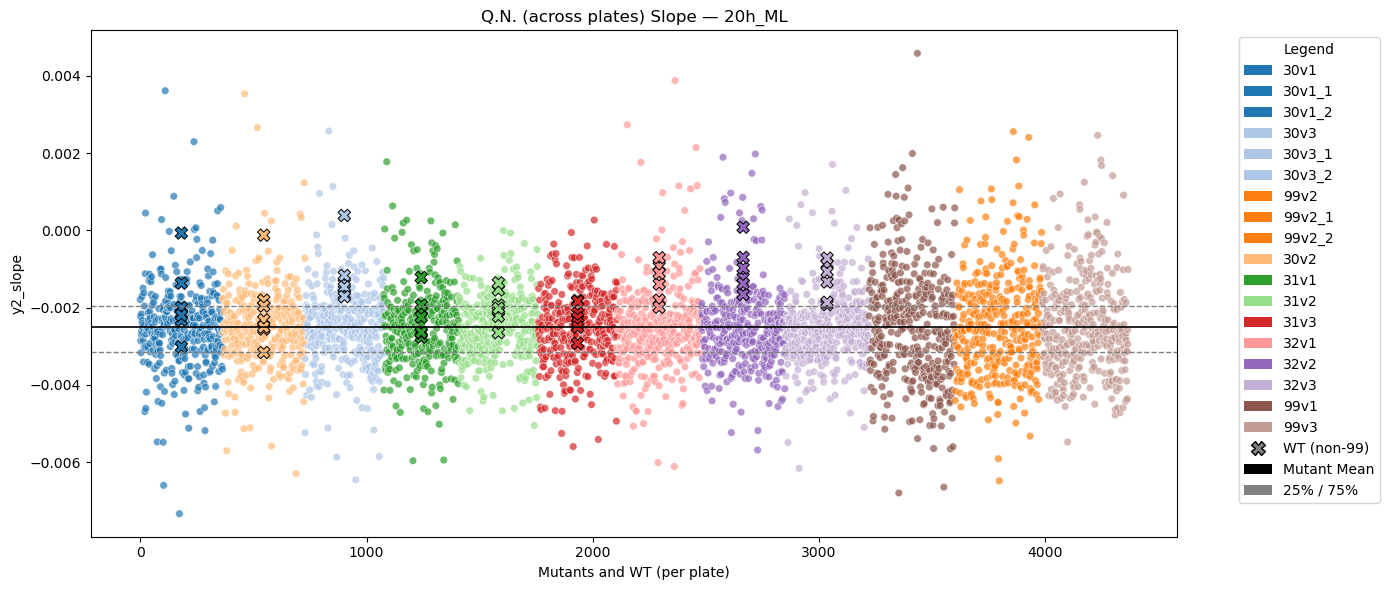

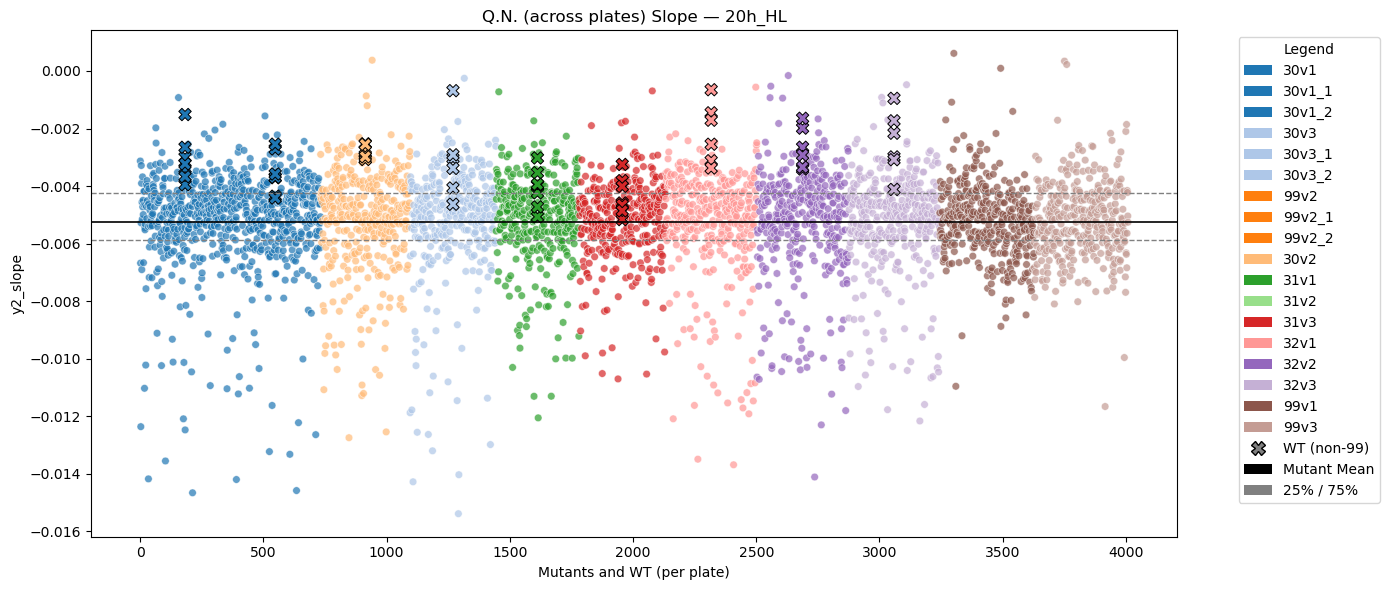

In [73]:
# Define plate groups
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['20h_ML', '20h_HL']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)


    # sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    # sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope'].mean()
    q1 = sub_df['y2_slope'].quantile(0.25)
    q3 = sub_df['y2_slope'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. (across plates) Slope — {regime}")
    plt.tight_layout()
    plt.show()


## compute 2 slopes

In [74]:
df_alter = phase2_qn_df_new[phase2_qn_df_new['light_regime'].isin(['2h-2h','10min-10min', '1min-1min', '30s-30s','5min-5min','1min-5min'])]
df_alter

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,elapsed_time_84,elapsed_time_85,elapsed_time_86,elapsed_time_87,elapsed_time_88,elapsed_time_89,elapsed_time_90,elapsed_time_91,y2_slope,y2_intercept
8809,30v1,M7,2024-06-14,2h-2h,14.942107,20.769634,100,0,1,0.619602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005182,0.345588
8811,30v1,M7,2024-06-14,2h-2h,14.942107,20.769634,100,0,3,0.551014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004631,0.325171
8812,30v1,M7,2024-06-14,2h-2h,14.942107,20.769634,100,0,4,0.678250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004494,0.426113
8813,30v1,M7,2024-06-14,2h-2h,14.942107,20.769634,100,0,5,0.697926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002969,0.409778
8814,30v1,M7,2024-06-14,2h-2h,14.942107,20.769634,100,0,6,0.646199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004161,0.384305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35997,30v2,M5,2024-06-21,30s-30s,15.074931,20.630035,180,15,19,0.634941,...,19.101389,19.593333,19.601944,20.093889,20.1025,20.358333,NaN,NaN,-0.000785,0.380745
35998,30v2,M5,2024-06-21,30s-30s,15.074931,20.630035,180,15,20,0.550535,...,19.101389,19.593333,19.601944,20.093889,20.1025,20.358333,NaN,NaN,-0.001118,0.315810
35999,30v2,M5,2024-06-21,30s-30s,15.074931,20.630035,180,15,21,0.615294,...,19.101389,19.593333,19.601944,20.093889,20.1025,20.358333,NaN,NaN,-0.000405,0.369152
36000,30v2,M5,2024-06-21,30s-30s,15.074931,20.630035,180,15,22,0.547181,...,19.101389,19.593333,19.601944,20.093889,20.1025,20.358333,NaN,NaN,-0.000812,0.319460


In [75]:
light_2h = pd.read_csv('Data light on off/20240917_99v1-M5_2h-2h.csv', sep=';')
light_2h = light_2h.loc[:, ~light_2h.columns.str.contains('^Unnamed')]
light_2h = light_2h.iloc[1:-1].reset_index(drop=True)

light_1min = pd.read_csv('Data light on off/20240913_99v1-M1_1min-1min.csv', sep=';')
light_1min = light_1min.loc[:, ~light_1min.columns.str.contains('^Unnamed')]
light_1min = light_1min.iloc[1:-1].reset_index(drop=True)

light_10min = pd.read_csv('Data light on off/20240919_99v1-M7_10min-10min.csv', sep=';')
light_10min = light_10min.loc[:, ~light_10min.columns.str.contains('^Unnamed')]
light_10min = light_10min.iloc[1:-1].reset_index(drop=True)

light_30s=pd.read_csv('Data light on off/20240918_99v1-M6_30s-30s.csv', sep=';')
light_30s = light_30s.loc[:, ~light_30s.columns.str.contains('^Unnamed')]
light_30s = light_30s.iloc[1:-1].reset_index(drop=True)

light_1min_5min = pd.read_csv('Data light on off/20240920_99v1-M8_1min-5min.csv', sep=';')
light_1min_5min = light_1min_5min.loc[:, ~light_1min_5min.columns.str.contains('^Unnamed')]
light_1min_5min = light_1min_5min.iloc[1:-1].reset_index(drop=True)

light_5min_5min = pd.read_csv('Data light on off/20241123_99v1-M8_5min-5min.csv', sep=';')
light_5min_5min = light_5min_5min.loc[:, ~light_5min_5min.columns.str.contains('^Unnamed')]
light_5min_5min = light_5min_5min.iloc[1:-1].reset_index(drop=True)

In [77]:
def feature_with_light_split(df, light_dict, n_timepoints_dict):
    """
    df: DataFrame in wide format (each row = one mutant)
    light_dict: dict mapping light_regime to corresponding light_XX DataFrame
    n_timepoints_dict: dict mapping light_regime to number of timepoints (40 or 80)
    """

    all_results = []

    for regime, group_df in df.groupby('light_regime'):
        
        if regime not in light_dict:
            continue  # skip if no light info provided for this regime

        light = light_dict[regime]
        n_timepoints = n_timepoints_dict[regime]

        # Extract ON/OFF mask
        par_values = light['PAR'].values[:n_timepoints]
        mask_on = par_values > 0
        mask_off = par_values == 0

        time_cols = [f'elapsed_time_{i}' for i in range(2, n_timepoints + 2)]
        y_cols = [f'y2_{i}' for i in range(1, n_timepoints + 1)]

        def compute_slopes(row):
            
            time_vals = row[time_cols].values.astype(float)
            y_vals = row[y_cols].values.astype(float)
        
            result = {
                'y2_slope_on': np.nan,
                'y2_intercept_on': np.nan,
                'y2_slope_off': np.nan,
                'y2_intercept_off': np.nan,
            }
        
            # ON
            # valid_on = mask_on & ~np.isnan(y_vals)
            valid_on = mask_on & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_on.sum() >= 2:
                model_on = LinearRegression()
                model_on.fit(time_vals[valid_on].reshape(-1, 1), y_vals[valid_on])
                result['y2_slope_on'] = model_on.coef_[0]
                result['y2_intercept_on'] = model_on.intercept_
        
            # OFF

            # valid_off = mask_off & ~np.isnan(y_vals)
            valid_off = mask_off & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_off.sum() >= 2:
                model_off = LinearRegression()
                model_off.fit(time_vals[valid_off].reshape(-1, 1), y_vals[valid_off])
                result['y2_slope_off'] = model_off.coef_[0]
                result['y2_intercept_off'] = model_off.intercept_
        
            return pd.Series(result)
        print(regime)

        slopes = group_df.apply(compute_slopes, axis=1)
        result = pd.concat([group_df, slopes], axis=1)
        #.reset_index(drop=True)
        all_results.append(result)

    # Combine results from all regimes
    return pd.concat(all_results, ignore_index=True)

In [78]:
light_dict = {
    '2h-2h': light_2h,
    '10min-10min': light_10min,
    '1min-1min': light_1min,
        '30s-30s': light_30s,

    '5min-5min':light_5min_5min,
    '1min-5min':light_1min_5min
}

n_timepoints_dict = {
    '2h-2h': 48,
    '10min-10min': 84,
    '1min-1min': 88,
    '30s-30s': 88,
    '5min-5min':88,
    '1min-5min':88
}

df1 = feature_with_light_split(df_alter, light_dict, n_timepoints_dict)

10min-10min
1min-1min
1min-5min
2h-2h
30s-30s
5min-5min


In [79]:
# Separate WT and mutants
wt_df =df1[df1['mutant_ID'] == 'WT']
mutant_df =df1[df1['mutant_ID'] != 'WT']

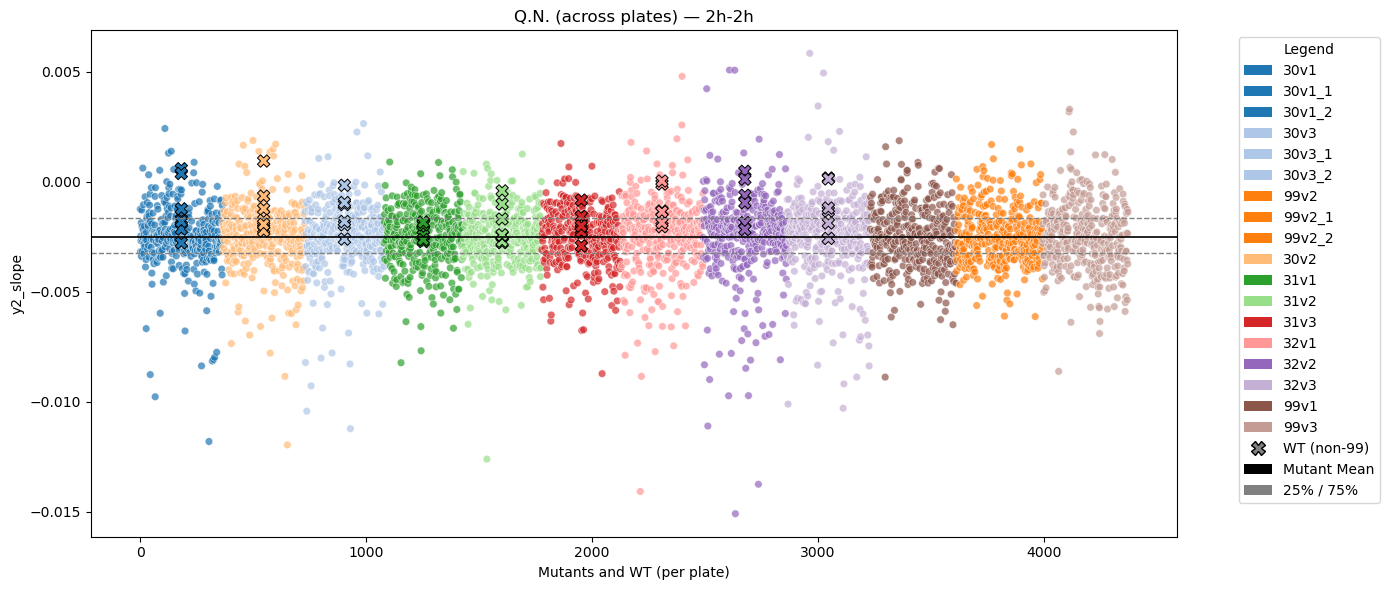

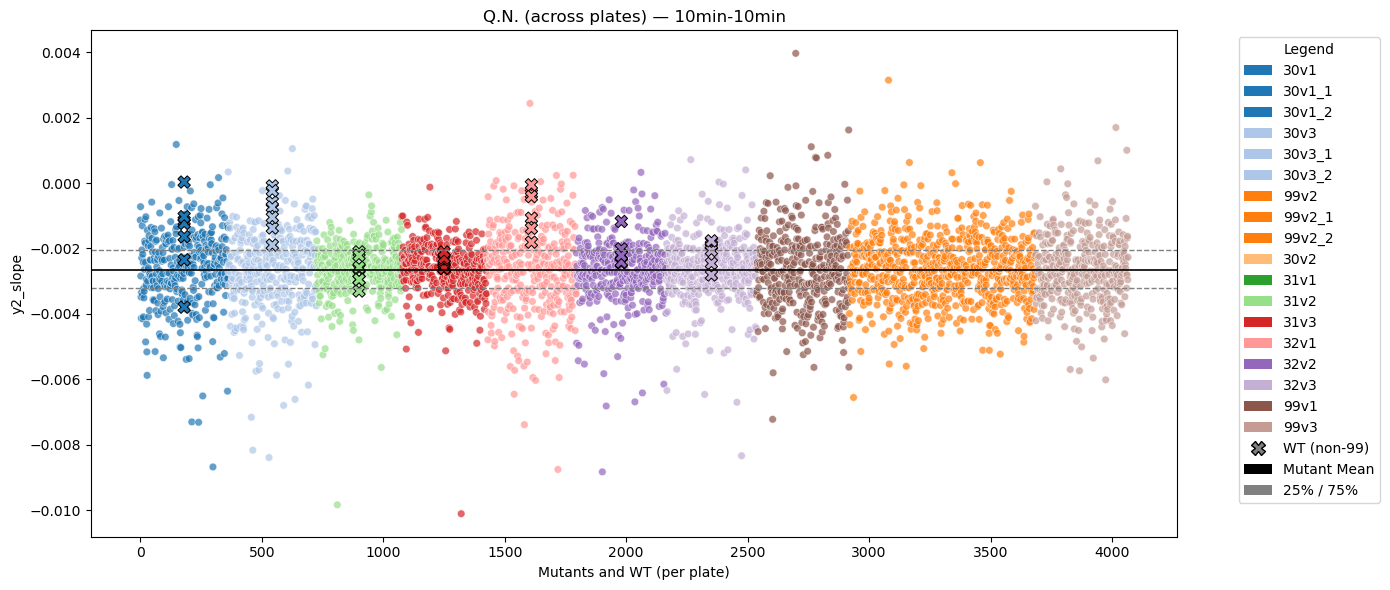

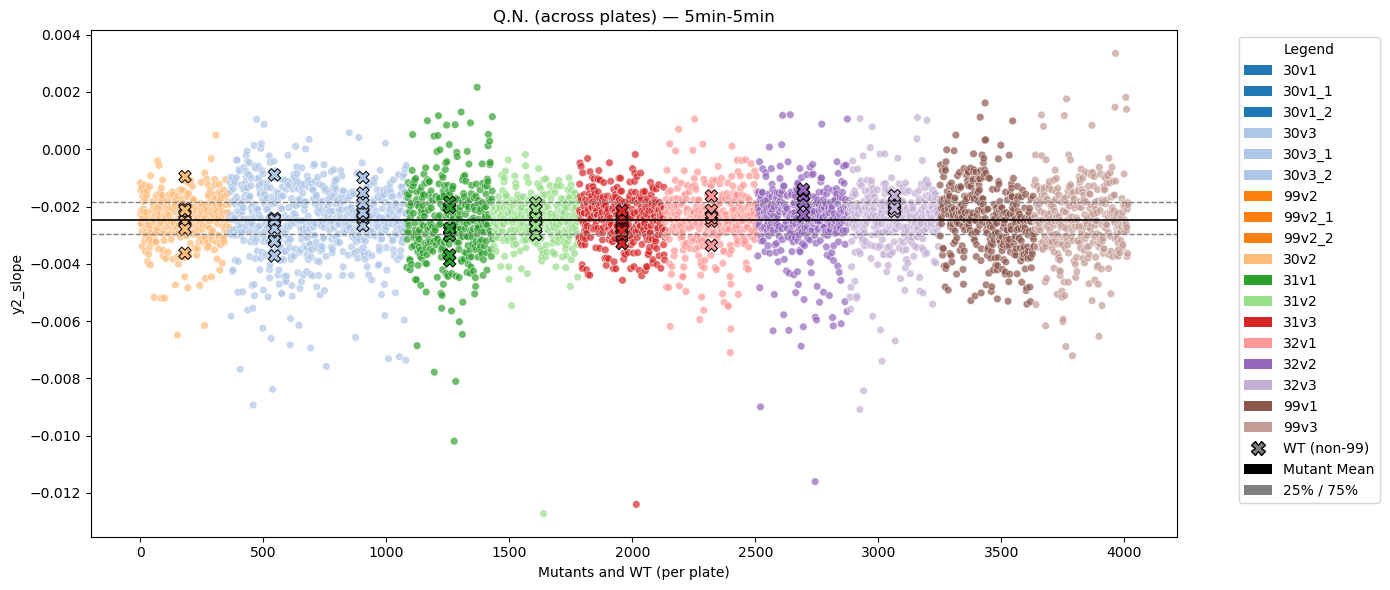

In [83]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['2h-2h','10min-10min', '5min-5min']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)


    # sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    # sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. (across plates) — {regime}")
    plt.tight_layout()
    plt.show()

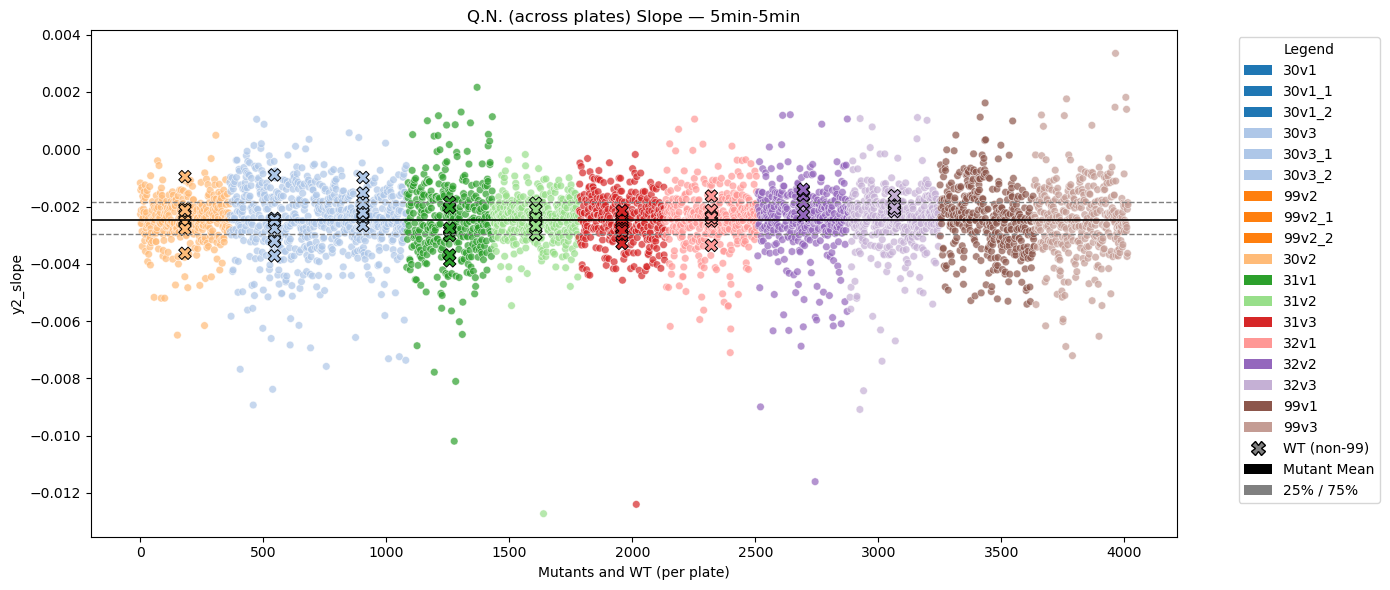

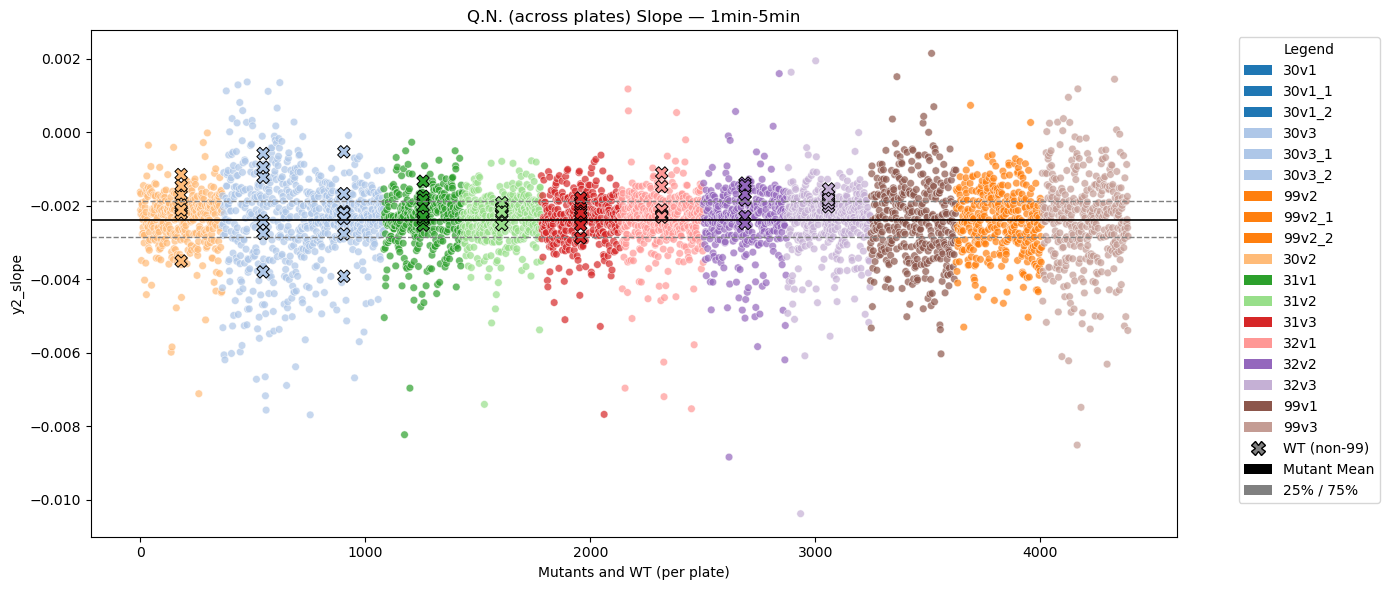

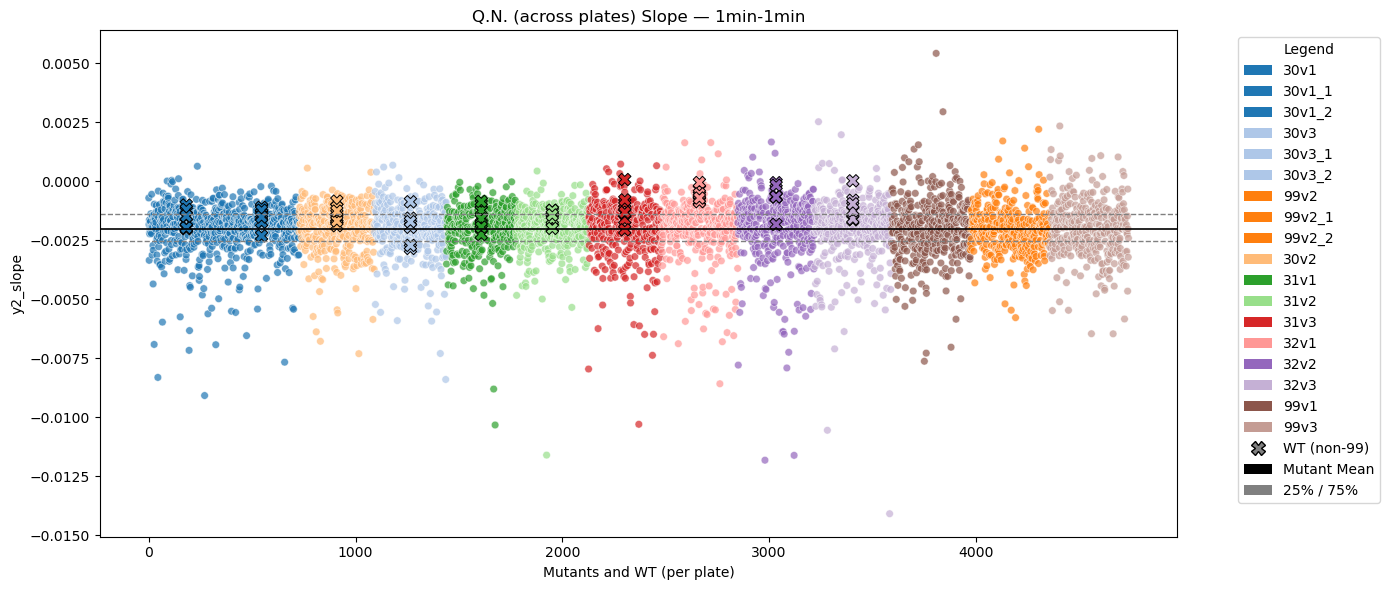

In [84]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['5min-5min','1min-5min', '1min-1min']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)


    # sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    # sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. (across plates) Slope — {regime}")
    plt.tight_layout()
    plt.show()

In [85]:
alt_light_regimes = ['2h-2h', '10min-10min', '1min-1min', '30s-30s', '5min-5min', '1min-5min']

# 2. Separate out the two subsets
df_alt= df1.copy()  # includes extra columns
df_non_alt = phase2_qn_df_new[~phase2_qn_df_new['light_regime'].isin(alt_light_regimes)].copy()

# 3. Make sure df_non_alt has the same columns (add missing columns as NaN)
for col in df_alt.columns:
    if col not in df_non_alt.columns:
        df_non_alt[col] = np.nan

# 4. Reorder columns to match df_alt
df_non_alt = df_non_alt[df_alt.columns]

# 5. Concatenate the full DataFrame
combined_df = pd.concat([df_alt, df_non_alt], ignore_index=True)
combined_df.shape

(34808, 825)

In [86]:
combined_df.to_csv('phase2_99_qn_across_slopes(5.18).csv',index=False)